### Interweek project: Adding new statistical releases via Differential Privacy

In the previous notebook, we wrote a series of functions that can release a differentially private mean (note the completed notebooks are updated on github).

In this notebook we are going to expand the number of statistics on a dataset we can release.  

First we will copy over the previous functions as our building blocks.

In [1]:
import numpy as np

def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=-0.5, high=0.5, size=size)
    draws = shift - scale * np.sign(p) * np.log(1 - 2 * abs(p))
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def clamp(x, bounds):
    """Replace any x_i less than lower with lower, 
           and any x_i greater than upper with upper."""
    lower, upper = bounds
    x_clamped = x.copy()
    x_clamped[x<lower] = lower
    x_clamped[x>upper] = upper
    return x_clamped

    # the easy way
    # return np.clip(x, *bounds)


def bounded_mean(x, bounds):
   # lower = min(x)
   # upper = max(x)
   # bounds = (lower, upper)

    x_clamped = clamp(x, bounds)
    bounded_mean = np.mean(x_clamped)
    return bounded_mean

    # the easy way
    # return np.mean(clamp(x,bounds))


def release_dp_mean(x, bounds, epsilon):
    """Release a DP mean. 
    Assumes that the dataset size n is public information.
    """

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = (upper - lower)/n
    scale = sensitivity/epsilon
    
    sensitive_answer = bounded_mean(x,bounds) 
    
    dp_mean = sensitive_answer + laplace(shift=0., scale=scale)
    return dp_mean

    # the compact way
    # return laplace(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))
    

We'll use the same dataset, again the Census PUMS release and the .Read in the data.  We're going to use the PUMS dataset we are familiar with, again focusing on the education variable, a 16 point scale.

In [2]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1., 16.)  # easily guessable without looking at the data

educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, bounds=educ_bounds, epsilon=1.))

10.610027954087725


# Problem 1: New Private Statistics

Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using.

In [13]:
def release_dp_count(x, bounds, epsilon):
    """Release a count of a predictate 
    (whether some statement is true for an individual). 
    Assumes that the dataset size n is public information.
    """

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = 1 # FIX THIS SENSITIVITY 
    scale = sensitivity/epsilon
    
    sensitive_answer = 1 # SUPPLY YOUR OWN PREDICATE, e.g., Has education >= 8.
    
    dp_median = 1 # FIX THIS
    return dp_mean

def release_dp_median(x, bounds, epsilon):
    """Release a DP median. 
    Assumes that the dataset size n is public information.
    """

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = 1 # FIX THIS SENSITIVITY
    scale = sensitivity/epsilon
    
    sensitive_answer = 1 # FIX THIS
    
    dp_median = 1 # FIX THIS
    return dp_mean


def release_dp_standard_deviation(x, bounds, epsilon):
    """Release a DP standard_deviation. 
    Assumes that the dataset size n is public information.
    """

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = 1 # FIX THIS SENSITIVITY
    scale = sensitivity/epsilon
    
    sensitive_answer = 1 # FIX THIS 
    # THIS ONE MIGHT BE PRETTY CHALLENGING TO DETERMINE.  
    # YOU CAN ROUGHLY APPROXIMATE
    
    dp_standard_deviation = 1 # FIX THIS
    return dp_standard_deviation


Here's a quick cell to check your function is releasing values

In [14]:
educ_bounds = (1., 16.)

output_count = release_count(educ, epsilon=1., bounds=educ_bounds)
output_median = release_median(educ, epsilon=1., bounds=educ_bounds)
output_standard_deviation = release_standard_deviation(educ, epsilon=1., bounds=educ_bounds)


print(output_count)
print(output_median)
print(output_standard_deviation)

[ 273.8618135   141.37619812  354.43878839  468.62607287  498.93307312
  755.74065383  890.9356503  1060.12857733 5146.31701029 1395.60782065
 3964.32515536 1153.34771691 6284.8339567  2268.7568327   796.11563631
  309.40758693]


# Problem 2: Utility Monte Carlo

Now plug in your new release functions into our simulation loops, and we can look at how good or bad these statistics perform. 

We're going to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable.  

We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [15]:
import math

def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]

    # the easy way
    # return np.random.choice(x, size=n)


n_sims = 1000

log_seq = np.linspace(start=math.log10(200), stop=math.log10(1500), num=15)
n_seq = (10**log_seq).astype(int)
print(n_seq)


log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=5)
ep_seq = (10**log_seq *100).astype(int)/100
print(ep_seq)

agg_history = []

aggcount = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(ep_seq):
        sq_error = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
            dp_mean = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
            dp_count = 1 # Add your release function here
            dp_median = 1 # Add your release function here
            dp_standard_deviation = 1 # Add your release function here 
            sq_error += (dp_mean - sensitive_mean) ** 2
            # CALCULATE THE ERRORS FOR YOUR NEW RELEASES
            
        # APPEND YOUR ERRORS IN THE HISTORY MATRIX BELOW    
        agg_history.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error/n_sims)  #RMSE
        ])
        
        aggcount += 1

agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "error"])


[ 200  230  266  307  355  410  474  547  632  730  843  974 1124 1298
 1500]
[1.   0.56 0.31 0.17 0.1 ]


Graphing our results is often a case of finding an approximate template and then tweaking it to convey the exact details of interest to your reader.  This template for showing the utility of DP releases will likely be commonly useful across your homeworks and project.

# PROBLEM 3: Plot Results

With minor alterations, you should be able to show your results using the following graph template.  Feel free to cut back the graphs we're showing to one per statistic.

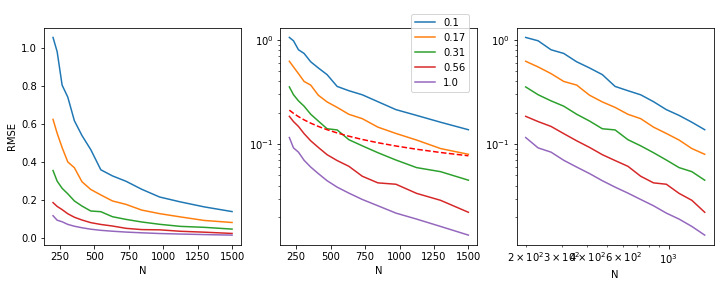

In [17]:

import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12,4)) 

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

## Overlay the standard error of the mean
se = np.std(educ) / np.sqrt(n_seq)
axs[1].plot(n_seq, se, linestyle='dashed', color="red")

_ = fig.legend(*axs[0].get_legend_handles_labels(), loc=(0.57, 0.68))


# Bonus Problem: 

Recalling that the slope parameter of a univariate linear regression is the ratio of the covariance of y and x to the variance of x, (S_xy/S_xx) can you write a DP release function for the slope parameter?  Use your standard deviation release function as a template.